In [2]:
!pip install lifetimes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3/3 [lifetimes]


In [44]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt


In [10]:
pip install openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [openpyxl]
Note: you may need to restart the kernel to use updated packages.


In [22]:

data = pd.read_excel(r'/Users/srishtiagarwal/Desktop/customer/online_retail_II.xlsx')
print("-" * 50)
print(" Data imported successfully!!")

# Styled display of top 3 rows
data.head(3).style.set_properties(
    **{"background-color": "#cd5c5c", "color": "black", "border-color": "black"}
)


--------------------------------------------------
 Data imported successfully!!


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.950000,13085.000000,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.750000,13085.000000,United Kingdom


In [23]:
pd.set_option('display.max_columns', None) 
def data_overview(df, head=5):
    print(" SHAPE OF DATASET ".center(125,'-'))
    print('Rows:{}'.format(df.shape[0]))
    print('Columns:{}'.format(df.shape[1]))
    print(" HEAD ".center(125,'-'))
    print(df.head(head))
    print("DATA TYPES".center(125,'-'))
    print(data.dtypes.value_counts())
    print(" MISSING VALUES ".center(125,'-'))
    print(df.isnull().sum()[df.isnull().sum()>0].sort_values(ascending = False))
    print(" DUPLICATED VALUES ".center(125,'-'))
    print(df.duplicated().sum())
    print(" STATISTICS OF DATA ".center(125,'-'))
    print(df.describe(include="all"))
    print("DATA INFO".center(125,'-'))
    print(df.info())
    
    
data_overview(data)

------------------------------------------------------ SHAPE OF DATASET -----------------------------------------------------
Rows:525461
Columns:8
------------------------------------------------------------ HEAD -----------------------------------------------------------
  Invoice StockCode                          Description  Quantity  \
0  489434     85048  15CM CHRISTMAS GLASS BALL 20 LIGHTS        12   
1  489434    79323P                   PINK CHERRY LIGHTS        12   
2  489434    79323W                  WHITE CHERRY LIGHTS        12   
3  489434     22041         RECORD FRAME 7" SINGLE SIZE         48   
4  489434     21232       STRAWBERRY CERAMIC TRINKET BOX        24   

          InvoiceDate  Price  Customer ID         Country  
0 2009-12-01 07:45:00   6.95      13085.0  United Kingdom  
1 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
2 2009-12-01 07:45:00   6.75      13085.0  United Kingdom  
3 2009-12-01 07:45:00   2.10      13085.0  United Kingdom  
4 200

In [24]:
#  Removing NaN's in Customer ID
print("Shape of data before removing NaN's CustomerID",data.shape)
data.dropna(subset="Customer ID",axis=0,inplace=True)
print("Shape of data after removing NaN's CustomerID",data.shape)

Shape of data before removing NaN's CustomerID (525461, 8)
Shape of data after removing NaN's CustomerID (417534, 8)


In [25]:
print("Missing values in each column after cleaning customerID :\n",data.isnull().sum())

Missing values in each column after cleaning customerID :
 Invoice        0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
Price          0
Customer ID    0
Country        0
dtype: int64


In [26]:
data = data[~data.Invoice.str.contains('C',na=False)]
print("Dataset is free from cancelled products information")


Dataset is free from cancelled products information


In [27]:
print("Number of duplicates before cleaning:",data.duplicated().sum())
data = data.drop_duplicates(keep="first")
print("Number of duplicates after cleaning:",data.duplicated().sum())

Number of duplicates before cleaning: 6748
Number of duplicates after cleaning: 0


In [28]:
print("Negative value in Quantity is:",(data.Quantity<0).sum())
print("Negative value in Price is:",(data.Price<0).sum())

Negative value in Quantity is: 0
Negative value in Price is: 0


In [29]:
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return up_limit, low_limit

def replace_with_threshold(dataframe, variable):
    up_limit, low_limit = outlier_thresholds(dataframe, variable)
    # dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

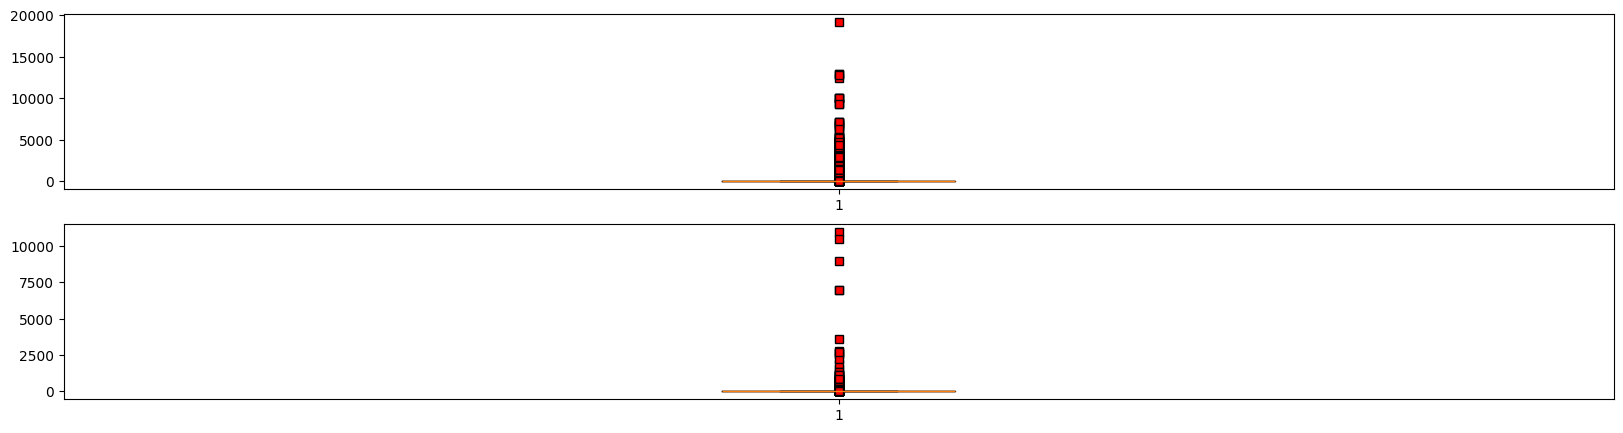

In [30]:
f, ax = plt.subplots(2,1, figsize = (20,5))
col_list = ["Quantity","Price"]
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()


In [31]:
replace_with_threshold(data, "Quantity")
replace_with_threshold(data, "Price")

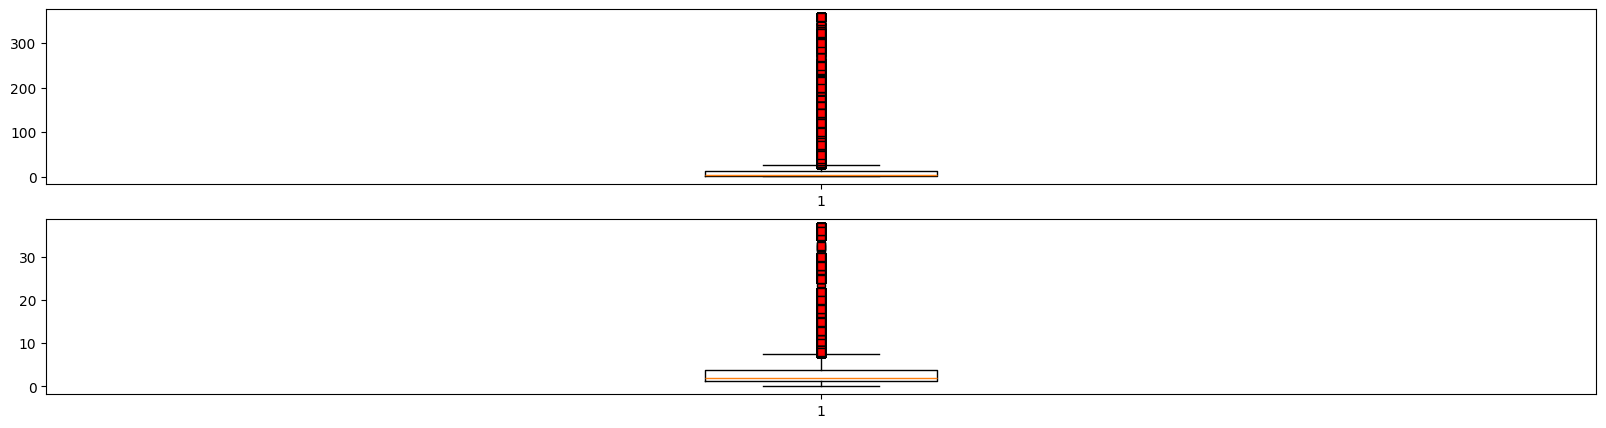

In [32]:
f, ax = plt.subplots(2,1, figsize = (20,5))
for i in range(0,2):
    ax[i].boxplot(data[col_list[i]],flierprops = dict(marker = "s", markerfacecolor = "red"), vert = 0)
plt.show()

In [33]:
data["Revenue"] = data["Quantity"] * data["Price"]

In [34]:
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

In [35]:
print("Max date :",data["InvoiceDate"].max())
print("Min date :",data["InvoiceDate"].min())

Max date : 2010-12-09 20:01:00
Min date : 2009-12-01 07:45:00


In [36]:
Latest_Date = dt.datetime(2011,12,10)

#Creating RFM features with subset of customerID
RFM = data.groupby('Customer ID').agg({'InvoiceDate': lambda x: (Latest_Date - x.max()).days, 
                                                 'Invoice': lambda x: x.nunique(), 
                                                 "Revenue": lambda x: x.sum()})
                                
RFM['InvoiceDate'] = RFM['InvoiceDate'].astype(int)

#Renaming column names to Recency, Frequency and Monetary
RFM.rename(columns={'InvoiceDate': 'Recency', 
                         'Invoice': 'Frequency', 
                         'Revenue': 'Monetary'}, inplace=True)

RFM.reset_index().head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Customer ID,Recency,Frequency,Monetary
0,12346.000000,529,11,372.860000
1,12347.000000,367,2,1323.320000
2,12348.000000,438,1,222.160000
3,12349.000000,407,3,2295.020000
4,12351.000000,375,1,300.930000


The Fourth varibale of RFM, InterPurchase Time, is a measure of average time gap between total shopping trips by a customer. The Interpurchase Time is calcluted as fallows :

T = L/(F-1) = (Tn - T1)/(F-1)

T --> Interpurchase Time
L --> Shopping Cycle
F --> Frequency
T1 --> First purchase
Tn --> Last purchase
Note: We consider only those customers who made purchase more than once.

In [37]:
RFM = RFM[(RFM["Frequency"]>1)]
RFM.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})


,Recency,Frequency,Monetary
Customer ID,,,
12346.000000,529,11,372.860000
12347.000000,367,2,1323.320000
12349.000000,407,3,2295.020000
12352.000000,375,2,343.800000
12356.000000,380,3,3560.300000


In [38]:
Shopping_Cycle = data.groupby('Customer ID').agg({'InvoiceDate': lambda x: ((x.max() - x.min()).days)})

In [39]:
RFM["Shopping_Cycle"] = Shopping_Cycle
RFM.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Shopping_Cycle
Customer ID,,,,
12346.000000,529,11,372.860000,196
12347.000000,367,2,1323.320000,37
12349.000000,407,3,2295.020000,181
12352.000000,375,2,343.800000,16
12356.000000,380,3,3560.300000,44


In [40]:
RFM["Interpurchase_Time"] = RFM["Shopping_Cycle"] // RFM["Frequency"]
RFMT = RFM[["Recency","Frequency","Monetary","Interpurchase_Time"]]
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time
Customer ID,,,,
12346.000000,529,11,372.860000,17
12347.000000,367,2,1323.320000,18
12349.000000,407,3,2295.020000,60
12352.000000,375,2,343.800000,8
12356.000000,380,3,3560.300000,14


In [42]:
!pip install yellowbrick


In [51]:
import numpy as np
from sklearn.preprocessing import StandardScaler

# Optional: clip extreme outliers (cap at 99th percentile)
RFMT_clipped = RFMT.copy()
for col in RFMT_clipped.columns:
    cap = RFMT_clipped[col].quantile(0.99)
    RFMT_clipped[col] = np.where(RFMT_clipped[col] > cap, cap, RFMT_clipped[col])

# Now scale
scaler = StandardScaler()
RFMT_scaled = scaler.fit_transform(RFMT_clipped)



In [53]:
for col in RFMT_clipped.columns:
    cap = RFMT_clipped[col].quantile(0.95)
    RFMT_clipped[col] = np.where(RFMT_clipped[col] > cap, cap, RFMT_clipped[col])


In [54]:
RFMT_log = RFMT.copy()
RFMT_log['Monetary'] = np.log1p(RFMT_log['Monetary'])
RFMT_log['Frequency'] = np.log1p(RFMT_log['Frequency'])
RFMT_log['Interpurchase_Time'] = np.log1p(RFMT_log['Interpurchase_Time'])

scaler = StandardScaler()
RFMT_scaled = scaler.fit_transform(RFMT_log)


In [55]:
import warnings
warnings.filterwarnings('ignore')


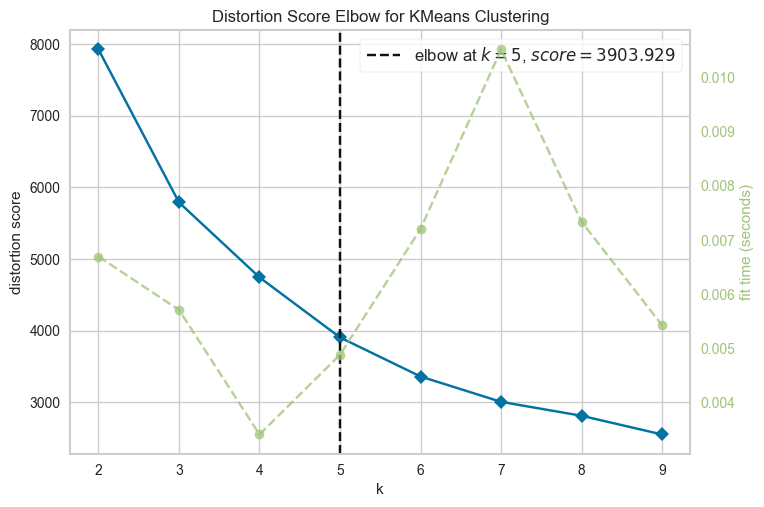

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [56]:
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Plot
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,10))

visualizer.fit(RFMT_scaled)
visualizer.show()


In [48]:
print(RFMT.info())
print(RFMT.describe())
print(RFMT.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
Index: 2893 entries, 12346.0 to 18287.0
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Recency             2893 non-null   int64  
 1   Frequency           2893 non-null   int64  
 2   Monetary            2893 non-null   float64
 3   Interpurchase_Time  2893 non-null   int64  
dtypes: float64(1), int64(3)
memory usage: 113.0 KB
None
           Recency    Frequency       Monetary  Interpurchase_Time
count  2893.000000  2893.000000    2893.000000         2893.000000
mean    425.541652     6.150709    2740.612223           45.055652
std      70.059252     9.527428   10002.177365           32.320116
min     365.000000     2.000000      24.050000            0.000000
25%     378.000000     2.000000     619.080000           22.000000
50%     399.000000     4.000000    1203.530000           39.000000
75%     444.000000     7.000000    2414.180000           61.000000
max

In [57]:
kmeans = KMeans(n_clusters=4,max_iter=50)
kmeans.fit(RFMT)

KMeans(max_iter=50, n_clusters=4)

In [58]:
RFMT["Clusters"]=kmeans.labels_
RFMT.head().style.set_properties(**{"background-color": "#cd5c5c","color": "black", "border-color": "black"})

,Recency,Frequency,Monetary,Interpurchase_Time,Clusters
Customer ID,,,,,
12346.000000,529,11,372.860000,17,2
12347.000000,367,2,1323.320000,18,2
12349.000000,407,3,2295.020000,60,2
12352.000000,375,2,343.800000,8,2
12356.000000,380,3,3560.300000,14,2


In [59]:
kmeans.cluster_centers_

array([[3.81000000e+02, 3.08690476e+01, 1.96268884e+04, 1.41785714e+01],
       [3.70000000e+02, 8.96666667e+01, 2.46359482e+05, 3.66666667e+00],
       [4.27078957e+02, 5.09431940e+00, 1.75544632e+03, 4.61257592e+01],
       [3.69142857e+02, 9.61428571e+01, 8.96228336e+04, 5.42857143e+00]])

<function matplotlib.pyplot.show(close=None, block=None)>

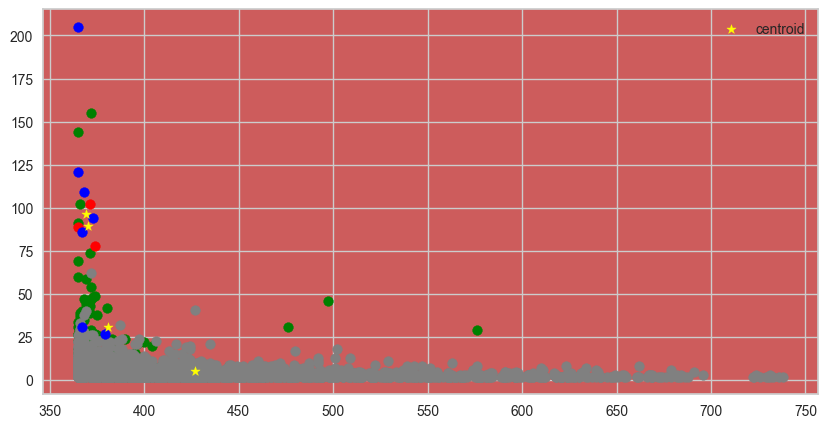

In [60]:
# grouping the data in accorandance with each cluster seperately
one = RFMT[RFMT["Clusters"]==0]
two = RFMT[RFMT["Clusters"]==1]
three = RFMT[RFMT["Clusters"]==2]
four = RFMT[RFMT["Clusters"]==3]

#Checking the quality of clustering in the data set
plt.figure(figsize=(10,5))
ax = plt.axes()
ax.set_facecolor("#cd5c5c")
plt.scatter(one["Recency"],one["Frequency"],color='green')
plt.scatter(two["Recency"],two["Frequency"],color='red')
plt.scatter(three["Recency"],three["Frequency"],color='grey')
plt.scatter(four["Recency"],four["Frequency"],color='blue')
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color="yellow",marker="*",label="centroid")
plt.legend()
plt.show 


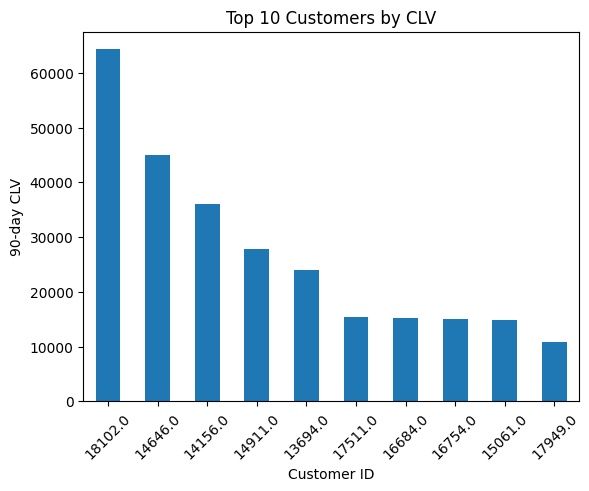

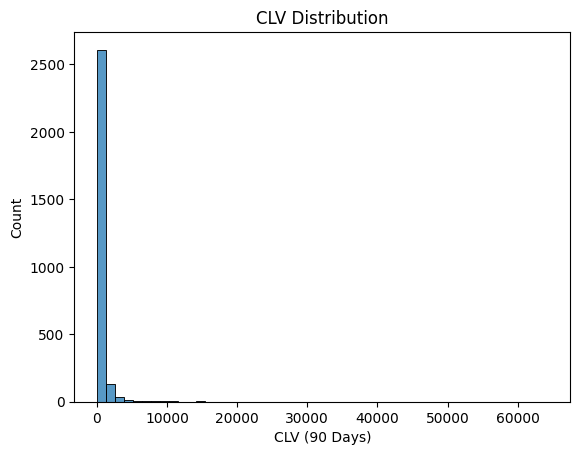

In [19]:
# Top 10 customers by CLV
top_customers = summary[['CLV_90_days']].head(10)
top_customers.plot(kind='bar', legend=False, title='Top 10 Customers by CLV')
plt.ylabel("90-day CLV")
plt.xticks(rotation=45)
plt.show()

# CLV Distribution
sns.histplot(summary['CLV_90_days'], bins=50)
plt.title("CLV Distribution")
plt.xlabel("CLV (90 Days)")
plt.show()


In [20]:
summary.to_csv("customer_lifetime_value_summary.csv")